<a href="https://colab.research.google.com/github/11kartheek/clip-sam/blob/main/clip_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install torch torchvision transformers
!pip -q install open_clip_torch
!pip -q install datasets[vision]
!pip -q install gradio

In [9]:
import open_clip
import torch
import gradio as gr
from PIL import Image
from datasets import load_dataset
import random

# Load the fruits dataset
dataset = load_dataset("VinayHajare/Fruits-30")

Resolving data files:   0%|          | 0/827 [00:00<?, ?it/s]

In [ ]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model.eval()  # model in train mode by default, impacts some models with BatchNorm or stochastic depth active
tokenizer = open_clip.get_tokenizer('ViT-B-32')


In [115]:
dataset.save_to_disk("./fruits_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/826 [00:00<?, ? examples/s]

In [116]:
from huggingface_hub import HfApi
api = HfApi()

In [117]:
from huggingface_hub import login
login()

In [118]:
api.upload_folder(
    folder_path="fruits_dataset",
    repo_id="Kartheekb7/clip_classification",
    repo_type="space",
)

data-00000-of-00001.arrow:   0%|          | 0.00/365M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spaces/Kartheekb7/clip_classification/commit/cc9132eb56cb51cff5199d38044d0df35b938f24', commit_message='Upload folder using huggingface_hub', commit_description='', oid='cc9132eb56cb51cff5199d38044d0df35b938f24', pr_url=None, pr_revision=None, pr_num=None)

In [121]:
from datasets import load_from_disk
dataset = load_from_disk("./fruits_dataset/train")

In [123]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 826
})

In [28]:
from collections import OrderedDict


FRUITS30_CLASSES = OrderedDict(
    {
           "0" : "acerolas",
           "1" : "apples",
           "2" : "apricots",
           "3" : "avocados",
           "4" : "bananas",
           "5" : "blackberries",
           "6" : "blueberries",
           "7" : "cantaloupes",
           "8" : "cherries",
           "9" : "coconuts",
           "10" : "figs",
           "11" : "grapefruits",
           "12" : "grapes",
           "13" : "guava",
           "14" : "kiwifruit",
           "15" : "lemons",
           "16" : "limes",
           "17" : "mangos",
           "18" : "olives",
           "19" : "oranges",
           "20" : "passionfruit",
           "21" : "peaches",
           "22" : "pears",
           "23" : "pineapples",
           "24" : "plums",
           "25" : "pomegranates",
           "26" : "raspberries",
           "27" : "strawberries",
           "28" : "tomatoes",
           "29" : "watermelons"
    }
)

In [85]:
labels = list(FRUITS30_CLASSES.values())

In [86]:


# Function to pick three random sets and shuffle labels
def prepare_game():
    # Pick 3 random indices
    indices = random.sample(range(len(dataset['train'])), 1)

    # Get images and their corresponding labels
    selected_images = [dataset['train'][i]['image'] for i in indices]

    return selected_images[0]



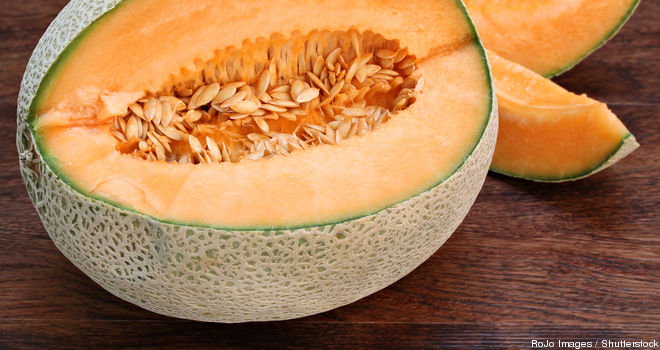

In [100]:
img = prepare_game()
img

In [109]:
def on_submit(img1,label1):
        image = preprocess(img1).unsqueeze(0)
        text = tokenizer(labels+[label1,"not a fruit"])

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        correct_label = FRUITS30_CLASSES[str(text_probs.argmax().item())]
        return correct_label

In [110]:
on_submit(img,'dog')

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


'cantaloupes'

In [106]:
FRUITS30_CLASSES[str(text_probs.argmax().item())]

'cantaloupes'

In [113]:
def create_interface():
    # Store current correct labels in a mutable container
    current_correct_labels = []

    def get_image():
        indices = random.sample(range(len(dataset['train'])), 1)
        selected_images = [dataset['train'][i]['image'] for i in indices]
        return selected_images[0]

    def on_submit(img1,label1):
        image = preprocess(img1).unsqueeze(0)
        text = tokenizer(labels+[label1,"not a fruit"])

        with torch.no_grad(), torch.cuda.amp.autocast():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        correct_label = FRUITS30_CLASSES[str(text_probs.argmax().item())]
        return correct_label

    with gr.Blocks() as demo:
        # Create components
        with gr.Row():
          img1 = gr.Image(type="pil", label="Fruit")
        with gr.Row():
          label1 = gr.Textbox(label="Name this fruit")

        submit_btn = gr.Button("Submit")
        refresh_btn = gr.Button("Refresh")

        result = gr.Textbox(label="Answer")

        # Update images, labels, and correct labels on refresh button click
        refresh_btn.click(
            fn=get_image,
            outputs=[img1]
        )


        # Evaluate user input on submit button click
        submit_btn.click(
            fn=on_submit,
            inputs=[img1,label1],
            outputs=result
        )

    demo.launch()

# Run the game
create_interface()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://aaaf3c42b8869ebb92.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
